In [1]:
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt

import re
import string

from tqdm import tqdm

# Data Cleanup

Looking at the data, we can see that there are many columns that we do not need such as the reviewers name, review time, summary etc. The columns we want are the 'reviewText', 'overall' and 'asin' columns. These represent the review, rating and product ID respectivley.

In [2]:
df = pd.read_json('../../Dataset/Reviews.json', lines = True)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,2,True,"12 11, 2011",AUVPE2KEXBJVT,9539723809,T. E. Kainz,I don't spend a lot on my flags because they r...,Good quality for the price,1323561600,NaN,NaN
1,5,NaN,True,"07 30, 2011",A2F6GES1MBOFXS,9539723809,BluesJamJim,"Super fast processing and shipping, if you are...",3'x5' Colorado State flag,1311984000,NaN,NaN
2,5,NaN,True,"05 4, 2016",A1SDVD3SZI1BAK,9539723809,Gabriel M Martinez,Great product. I would recommend this product...,Colorado Flag,1462320000,NaN,NaN
3,5,NaN,True,"11 2, 2015",A1ZQJ3KCSLUPR3,9539723809,RAJ THE FLASH,GREAT PRICE I LOVE MY STATE AND COUNTRY,RETIRED MILITARY,1446422400,NaN,NaN
4,5,NaN,True,"09 1, 2015",ANU8FBZM618M3,9539723809,James R. Mills,Great display flag for the den.,Five Stars,1441065600,NaN,NaN


In [3]:
df = df[['overall', 'reviewText', 'asin']]
df.head()

,overall,reviewText,asin
0,5,I don't spend a lot on my flags because they r...,9539723809
1,5,"Super fast processing and shipping, if you are...",9539723809
2,5,Great product. I would recommend this product...,9539723809
3,5,GREAT PRICE I LOVE MY STATE AND COUNTRY,9539723809
4,5,Great display flag for the den.,9539723809


We can use the pandas describe function and value counts function to look at how the data is distributed. As we can see the data is heavily skewed towards 5 stars with 66% of the reviews being 5 stars and an average of 4.3 stars across the whole dataset.

In [4]:
df.describe()

,overall
count,798415.000000
mean,4.321493
std,1.174888
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
overall_counts = df['overall'].value_counts()
overall_percentages = (overall_counts/len(df)) * 100

print('Overall percentages: ')
print(overall_percentages)

Overall percentages: 
5    66.832787
4    15.454619
3     7.198637
1     6.456918
2     4.057038
Name: overall, dtype: float64


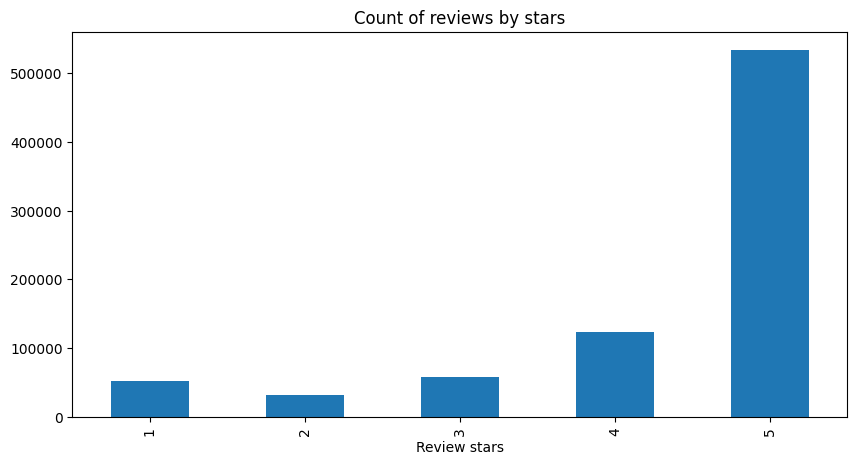

In [6]:
ax = df['overall'].value_counts().sort_index()\
    .plot(kind = 'bar',
         title = 'Count of reviews by stars',
         figsize=(10,5))

ax.set_xlabel('Review stars')
plt.show()

Some of the data within the dataframe contains null values for the review text columns. We need to remove these as they are unusable for our purposes.

In [7]:
df.isnull().mean()

overall       0.000000
reviewText    0.000233
asin          0.000000
dtype: float64

In [8]:
df.dropna(inplace = True)

In [9]:
df.isnull().mean()

overall       0.0
reviewText    0.0
asin          0.0
dtype: float64

We will also need to filter out exceptionally small and large reviews. To do this we will first need to remove unwanted characters such as white space, special characters and html tags.

In [10]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Replace special characters with their ASCII equivalent
    text = text.replace("’", "'").replace("‘", "'").replace("“", '"').replace("”", '"')
    
    return text

In [11]:
tqdm.pandas()
df['reviewText'] = df['reviewText'].progress_apply(clean_text)
df.head()

100%|███████████████████████████████████████████████████████████████████████| 798229/798229 [00:11<00:00, 70924.20it/s]


,overall,reviewText,asin
0,5,I don't spend a lot on my flags because they r...,9539723809
1,5,"Super fast processing and shipping, if you are...",9539723809
2,5,Great product. I would recommend this product....,9539723809
3,5,GREAT PRICE I LOVE MY STATE AND COUNTRY,9539723809
4,5,Great display flag for the den.,9539723809


We can see that there are some reviews with a length of 0 even though we removed null values. There are also some very large reviews, we should remove these to improve the training speed of our machine learning algorithms. This will also help reduce our dataset size.

In [12]:
review_lengths = df['reviewText'].str.len()

max_length = review_lengths.max()
min_length = review_lengths.min()
avg_length = review_lengths.mean()
std_length = review_lengths.std()

print('Maximum review length: ', max_length)
print('Minimum review length: ', min_length)
print('Average review length: ', avg_length)
print('Standard deviation of review length: ', std_length)

Maximum review length:  29855
Minimum review length:  0
Average review length:  243.09822619824638
Standard deviation of review length:  421.2814790006786


In [13]:
num_entries = df.shape[0]

print('Number of entries: ', num_entries)

Number of entries:  798229


Filter out reviews that are too short or too long

In [14]:
min_length = 250
max_length = 1000
filtered_df = df[df['reviewText']
                 .str
                 .lower()
                 .replace('[^\w\s]', '', regex=True)
                 .str.len()
                 .between(min_length, max_length)]

In [15]:
review_lengths = filtered_df['reviewText'].str.len()

max_length = review_lengths.max()
min_length = review_lengths.min()
avg_length = review_lengths.mean()
std_length = review_lengths.std()

print('Maximum review length: ', max_length)
print('Minimum review length: ', min_length)
print('Average review length: ', avg_length)
print('Standard deviation of review length: ', std_length)

Maximum review length:  1139
Minimum review length:  250
Average review length:  485.84131216530653
Standard deviation of review length:  196.9117024872207


After dropping some text data, we can see that we still have around 180,000 data entries which is more than enough.

In [16]:
filtered_df.head()

,overall,reviewText,asin
0,5,I don't spend a lot on my flags because they r...,9539723809
9,5,A very dear friend of mine is slowly losing he...,B00000JSZH
14,5,This is absolutely exquisite! It's made of car...,B00000JSZH
20,4,"This is really nice to use, however, just not ...",B00000JSZH
21,5,This Angel is beautiful. I as so glad I chose ...,B00000JSZH


In [17]:
num_entries = filtered_df.shape[0]

print('Number of entries: ', num_entries)

Number of entries:  179642


The data still generally follows the same bias as before. It is slightly less skewed towards 5 stars however.

In [18]:
filtered_df.describe()

,overall
count,179642.000000
mean,4.088621
std,1.307608
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [19]:
overall_counts = filtered_df['overall'].value_counts()
overall_percentages = overall_counts / len(filtered_df) * 100

print('Overall percentages: ')
print(overall_percentages)

Overall percentages: 
5    57.242182
4    18.392692
3     9.408156
1     9.058015
2     5.898955
Name: overall, dtype: float64


In [20]:
filtered_df.to_csv('../Data/filtered_data.csv', index=False)